# Generate auxiliary features

# TOC

* [1 Loading the data](#1-Loading-the-data)
* [2 Adding date features](#2-Adding-date-features)
* [3 Adding text features](#3-Adding-text-features)
* [4 Adding leakage features](#4-Adding-leakage-features)
* [5 The big merge](#5-The-big-merge)
* [6 Type casting](#6-Type-casting)
* [7 DataFrame trimming](#7-DataFrame-trimming)
* [8 Normalization](#8-Normalization)

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import requests
import re
import nltk
import sklearn
import gc
import pandas as pd
import numpy as np
from sklearn import decomposition
from pathlib import Path
from dateutil.relativedelta import relativedelta

# 1 Loading the data

In [3]:
data_dir = Path('.').absolute().joinpath('data')

sales_train = pd.read_csv(data_dir.joinpath('sales_train.csv.gz'))
sales_test = pd.read_csv(data_dir.joinpath('test.csv.gz'))
items = pd.read_csv(data_dir.joinpath('items.csv'))
item_categories = pd.read_csv(data_dir.joinpath('item_categories.csv'))
shops = pd.read_csv(data_dir.joinpath('shops.csv'))

In [4]:
generated_data = Path('.').absolute().joinpath('generated_data')
data_aggregate = pd.read_hdf(generated_data.joinpath('data_aggregate.hdf'),
                             key='data_aggregate')

In [5]:
n_train_samples = data_aggregate.shape[0]

Cast the dates to actual dates for easier manipulation

In [6]:
sales_train.loc[:, 'date'] = pd.to_datetime(sales_train.loc[:, 'date'], format='%d.%m.%Y')

# 2 Adding date features

In [7]:
dates = sales_train.loc[:, ['date_block_num', 'date']]

# Add one date in place of the dates for prediction
# NOTE: The relativedelta module takes care of problems with dates ending with 28, 30, 31
next_month = dates.loc[:, 'date'].max() + relativedelta(months=1)
next_date_block_num = dates.loc[:, 'date_block_num'].max() + 1
test_month = pd.DataFrame({'date_block_num':[next_date_block_num], 'date':[next_month]})
dates = pd.concat([dates, test_month], axis=0)

In [8]:
dates['date'].max()

Timestamp('2015-11-30 00:00:00')

Recall from the EDA that we found out that the last date in dataset was `2015-10-31`, this means we are going to predict for `2015-11`. 

Further, we note that only the year and month data is present in the test dataset, meaning that using information on the day level does not make sense.

### Standard date features

We here add date features as seasonal trends are present in the dataset

In [9]:
dates.loc[:, 'year'] = dates.loc[:, 'date'].dt.year
dates.loc[:, 'month'] = dates.loc[:, 'date'].dt.month
dates.loc[:, 'days_in_month'] = dates.loc[:, 'date'].dt.days_in_month
dates.loc[:, 'quarter'] = dates.loc[:, 'date'].dt.quarter

### Holidays

We will here generate the number of holidays in the previous month, the current month and the next month

In [10]:
def get_russian_holidays(year):
    """
    Returns a Series of Russian holidays in a given year
    
    Parameters
    ----------
    year : int
        The year to investigate
    
    Returns
    -------
    holidays : Series
        Series of the holidays on datetime64 format
    """
    
    url = f'https://www.timeanddate.com/holidays/russia/{year}'
    headers = {"Accept-Language": "en-US,en;q=0.5"}
    html = requests.get(url, headers=headers).content
    # A list is returned
    table_df = pd.read_html(html)[0].dropna()
    # Rename
    table_df = table_df.rename(columns={'Date': 'date'})
    table_df['date'] = table_df['date'].astype("string") + " {}".format(year)
    holidays = table_df['date'].apply(lambda x: pd.to_datetime(x, format='%d %b %Y'))

    return holidays

In [11]:
def get_year_months_len(df):
    """
    Returns the number of entries grouped by year and month of the input data frame
    
    Parameters
    ----------
    df : DataFrame
        DataFrame with a column named 'date'
    
    Returns
    -------
    df : DataFrame
        The input DataFrame where the number of entries grouped by year and month
        is appended to the column named 'year_month_count' 
    """
    
    new_df = df.copy()
    
    new_df.loc[:, 'year'] = new_df.loc[:, 'date'].dt.year
    new_df.loc[:, 'month'] = new_df.loc[:, 'date'].dt.month
    
    df.loc[:, 'year_month_count'] = new_df.groupby(['year', 'month'])['date'].transform(len)
    
    return df

In [12]:
# NOTE: We include 2012 to get the first prev_holiday_count later
holiday_2012 = get_russian_holidays(2012)
holiday_2013 = get_russian_holidays(2013)
holiday_2014 = get_russian_holidays(2014)
holiday_2015 = get_russian_holidays(2015)
holidays = pd.concat([holiday_2012, holiday_2013, holiday_2014, holiday_2015])

In [13]:
holiday_count = get_year_months_len(holidays).rename(columns={'year_month_count': 'holiday_count'})

Let's now generate the previous month holidays count.
We can get that by increasing the month by one (if the holiday count of February was 1 and the holiday count of March was 2, the holiday count of March will be 1).

In [14]:
prev_holiday_count = holiday_count.copy()
prev_holiday_count.loc[:, 'date'] = prev_holiday_count.loc[:, 'date'] + pd.DateOffset(months=1)
prev_holiday_count = prev_holiday_count.rename(columns={'holiday_count': 'prev_holiday_count'})

Likewise, we can find the next month holiday count by subtracting the months by 1

In [15]:
next_holiday_count = holiday_count.copy()
next_holiday_count.loc[:, 'date'] = next_holiday_count.loc[:, 'date'] + pd.DateOffset(months=-1)
next_holiday_count = next_holiday_count.rename(columns={'holiday_count': 'next_holiday_count'})

We drop the `date` and create `year` and `month` features we can merge on. 

**NOTE**: In order to merge the date data smoothly afterwards, we should drop the resulting duplicates

In [16]:
holiday_count.loc[:, 'year'] = holiday_count.loc[:, 'date'].dt.year
holiday_count.loc[:, 'month'] = holiday_count.loc[:, 'date'].dt.month
holiday_count.drop(['date'], axis=1, inplace=True)
holiday_count.drop_duplicates(inplace=True)

In [17]:
prev_holiday_count.loc[:, 'year'] = prev_holiday_count.loc[:, 'date'].dt.year
prev_holiday_count.loc[:, 'month'] = prev_holiday_count.loc[:, 'date'].dt.month
prev_holiday_count.drop(['date'], axis=1, inplace=True)
prev_holiday_count.drop_duplicates(inplace=True)

In [18]:
next_holiday_count.loc[:, 'year'] = next_holiday_count.loc[:, 'date'].dt.year
next_holiday_count.loc[:, 'month'] = next_holiday_count.loc[:, 'date'].dt.month
next_holiday_count.drop(['date'], axis=1, inplace=True)
next_holiday_count.drop_duplicates(inplace=True)

We merge the previous, current and next holiday count into one frame.
The resulting `NaN`s will be locations without vacations.
We start by merging with `dates`, as this contains all relevant `year`-`month` combinations

In [19]:
holidays = pd.merge(dates.loc[:, ['year', 'month']].drop_duplicates(),
                    holiday_count, how='left', on=['year', 'month']).fillna(0)
holidays = pd.merge(holidays, prev_holiday_count, how='left', on=['year', 'month']).fillna(0)
holidays = pd.merge(holidays, next_holiday_count, how='left', on=['year', 'month']).fillna(0)

# Re-shuffle the columns for better overview
holidays = holidays.loc[:, ['year', 'month', 'prev_holiday_count', 'holiday_count', 'next_holiday_count']]

# All columns can be integers
holidays = holidays.astype(np.int32)

# Sort by year and month for better overview
holidays.sort_values(['year', 'month'], inplace=True)
holidays.reset_index(inplace=True, drop=True)

# Add the date block number
holidays.loc[:, 'date_block_num'] = range(holidays.shape[0])

Inspect that we did the correct thing

In [20]:
holidays

,year,month,prev_holiday_count,holiday_count,next_holiday_count,date_block_num
0,2013,1,2,8,2,0
1,2013,2,8,2,2,1
2,2013,3,2,2,0,2
3,2013,4,2,0,7,3
4,2013,5,0,7,3,4
5,2013,6,7,3,1,5
6,2013,7,3,1,2,6
7,2013,8,1,2,2,7
8,2013,9,2,2,1,8
9,2013,10,2,1,2,9


This looks correct. Let's merge these to a common data frame.

In [21]:
dates = pd.merge(dates.drop('date', axis=1).drop_duplicates(),
                 holidays.drop(['year', 'month'] ,axis=1),
                 how='left', 
                 on='date_block_num')

In [22]:
del holiday_count
del next_holiday_count
del prev_holiday_count
del holiday_2012
del holiday_2013
del holiday_2014
del holiday_2015
del holidays
gc.collect()

0

# 3 Adding text features

Taking into the possibility that the names are correlated to the target, we add some text features as well. We split `item_name`, `shop_name` and `item_category_name` into cyrillic and latin words. We will stem these, and then combine them again before fitting a TF-IDF model to them.

**NOTE**: The TF-IDF model does not care about the relative position of the words, so it is ok if the order is scrambled when recombining the words to sentences again.

We would now like to stem the words (ideally we would like to lemmatize the words, but it looks like the lemmatization for non-english languages are not as readily available at the moment).

**NOTE**: The stemmer casts to lowercase

In [23]:
russian_stemmer = nltk.stem.SnowballStemmer('russian')
english_stemmer = nltk.stem.SnowballStemmer('english')

In [24]:
def separate_cyrillic_latin(words):
    """
    Separates the cyrillic and latin words
    
    Notes
    -----
    This function does not conserve word order
    
    Parameters
    -----------
    words : str
        The string of words to be split
        
    Returns
    -------
    separated_words : str
        The words separated by _SEP_
        Cyrillic words are to the left of the separator, the latin to the right
    """
    
    words_split = words.split(' ')
    cyrillic_words = list()
    latin_words = list()
    
    for word in words_split:
        # https://stackoverflow.com/questions/48255244/python-check-if-a-string-contains-cyrillic-characters
        if re.search('[а-яА-Я]', word) is not None:
            cyrillic_words.append(word)
        else:
            latin_words.append(word)
    
    cyrillic_words = ' '.join(cyrillic_words)
    latin_words = ' '.join(latin_words)
    
    separated_words = f'{cyrillic_words}_SEP_{latin_words}'
    
    return separated_words

In [25]:
def get_text_features(df, col, return_all=False):
    """
    Returns a new DataFrame with added text features
    
    Parameters
    -----------
    df : DataFrame
        The data frame to add the text features to
    col : str
        The column to obtain the text features from
    return_all : bool
        If True, intermediate columns will be returned
        
    Returns
    -------
    df_nlp : DataFrame
        The data frame with the added text features
        * {col}_clean - col column cleaned so that only alphabetical and numerical characters are present 
                        (only returned if return_all is True)
        * cyrillic_latin - column where cyrillic and latin letters has been separated 
                           (only returned if return_all is True)
        * cyrillic - column with only stemmed cyrillic words present (only returned if return_all is True)
        * latin - column with only stemmed latin words present (only returned if return_all is True)
        * {col}_nlp - combination of the cyrillic and latin column described above
        * {col}_cyrillic_words - cyrillic word count
        * {col}_latin_words - latin word count
        * {col}_total_words - total word count
    """
    
    df_nlp = df.copy()
    
    # First we clean the text by removing non-alphabetical characters and non-numeric characters
    
    df_nlp.loc[:, f'{col}_clean'] = \
    df_nlp.loc[:, f'{col}'].apply(lambda s: re.sub('[^а-яА-Яa-zA-Z0-9 ]', ' ', s))

    # Remove duplicated whitespaces
    df_nlp.loc[:, f'{col}_clean'] = \
        df_nlp.loc[:, f'{col}_clean'].apply(lambda s: re.sub(' +',' ', s))
    
    df_nlp.loc[:, 'cyrillic_latin'] = df_nlp.loc[:, f'{col}_clean'].apply(separate_cyrillic_latin)
    df_nlp.loc[:, 'cyrillic'] = df_nlp.loc[:, 'cyrillic_latin'].apply(lambda s: s.split('_SEP_')[0])
    df_nlp.loc[:, 'latin'] = df_nlp.loc[:, 'cyrillic_latin'].apply(lambda s: s.split('_SEP_')[1])
    
    df_nlp.loc[:, 'cyrillic'] = df_nlp.loc[:, 'cyrillic'].apply(russian_stemmer.stem)
    df_nlp.loc[:, 'latin'] = df_nlp.loc[:, 'latin'].apply(english_stemmer.stem)
    
    # Recombine words
    df_nlp.loc[:, f'{col}_nlp'] = df_nlp.loc[:, 'cyrillic'].str[:] + ' ' + df_nlp.loc[:, 'latin'].str[:]
    
    # We add the word count of each type together with the total.
    # The rationale for doing is
    # 1. It's possible that product with complex names are not sold as much
    # 2. In case there is a lot of English words in the product, it could be that it's less sellable in Russia
    # 3. Possible other reasons not mentioned here
    
    df_nlp.loc[:, f'{col}_cyrillic_words'] = \
        df_nlp.loc[:, 'cyrillic'].apply(lambda s: len(s.split(' ')) if s != '' else 0)
    df_nlp.loc[:, f'{col}_latin_words'] = \
        df_nlp.loc[:, 'latin'].apply(lambda s: len(s.split(' ')) if s != '' else 0)
    
    # NOTE: This is in fact an interaction feature
    df_nlp.loc[:, f'{col}_total_words'] = \
        df_nlp.loc[:, f'{col}_cyrillic_words'] + df_nlp.loc[:, f'{col}_latin_words']
    
    if not return_all:
        remove = [f'{col}_clean', 'cyrillic_latin', 'cyrillic', 'latin']
        df_nlp.drop(remove, axis=1, inplace=True)
    
    return df_nlp

In [26]:
item_nlp = get_text_features(items, 'item_name')
item_category_nlp = get_text_features(item_categories, 'item_category_name')
shop_nlp = get_text_features(shops, 'shop_name')

Check how many tokens we are dealing with

In [27]:
item_corpus = ' '.join(item_nlp.loc[:, 'item_name_nlp'].values)
item_corpus_tokens = nltk.word_tokenize(item_corpus)
print(f'Unique item_name_tokens {len(set(item_corpus_tokens))}')

Unique item_name_tokens 19123


In [28]:
item_category_corpus = ' '.join(item_category_nlp.loc[:, 'item_category_name_nlp'].values)
item_category_corpus_tokens = nltk.word_tokenize(item_category_corpus)
print(f'Unique item_category_name_tokens {len(set(item_category_corpus_tokens))}')

Unique item_category_name_tokens 114


In [29]:
shop_corpus = ' '.join(shop_nlp.loc[:, 'shop_name_nlp'].values)
shop_corpus_tokens = nltk.word_tokenize(shop_corpus)
print(f'Unique shop_name_tokens {len(set(shop_corpus_tokens))}')

Unique shop_name_tokens 118


We should take care not to use all tokens as this may result in a [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality). 
Let's see how the words are distributed

In [30]:
samples = 30

<IPython.core.display.Javascript object>


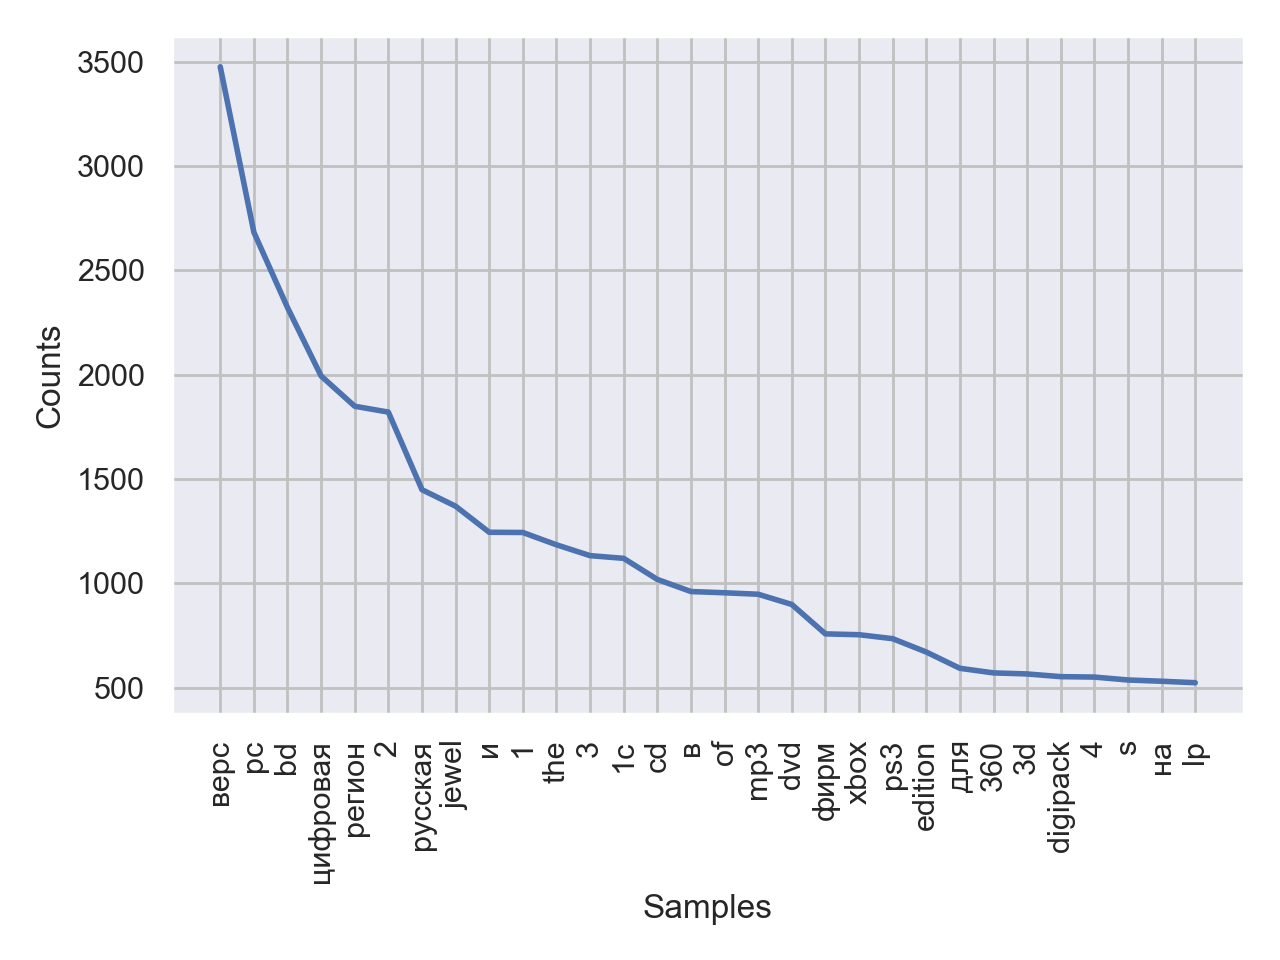

In [31]:
plt.figure()
fd_item = nltk.FreqDist(item_corpus_tokens)
fd_item.plot(samples, cumulative=False)
plt.tight_layout()

<IPython.core.display.Javascript object>


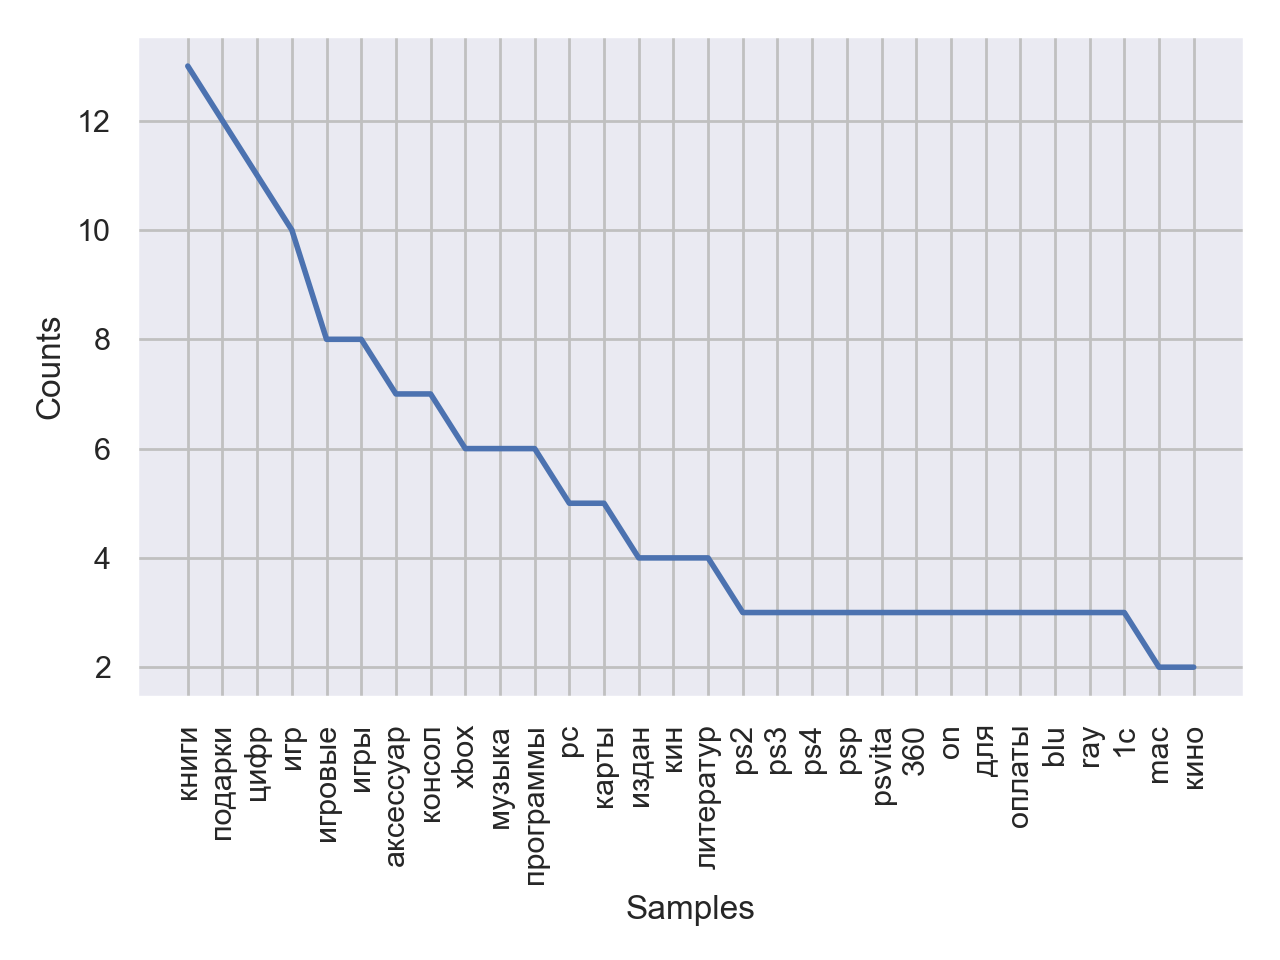

In [32]:
plt.figure()
fd_item_category = nltk.FreqDist(item_category_corpus_tokens)
fd_item_category.plot(samples, cumulative=False)
plt.tight_layout()

<IPython.core.display.Javascript object>


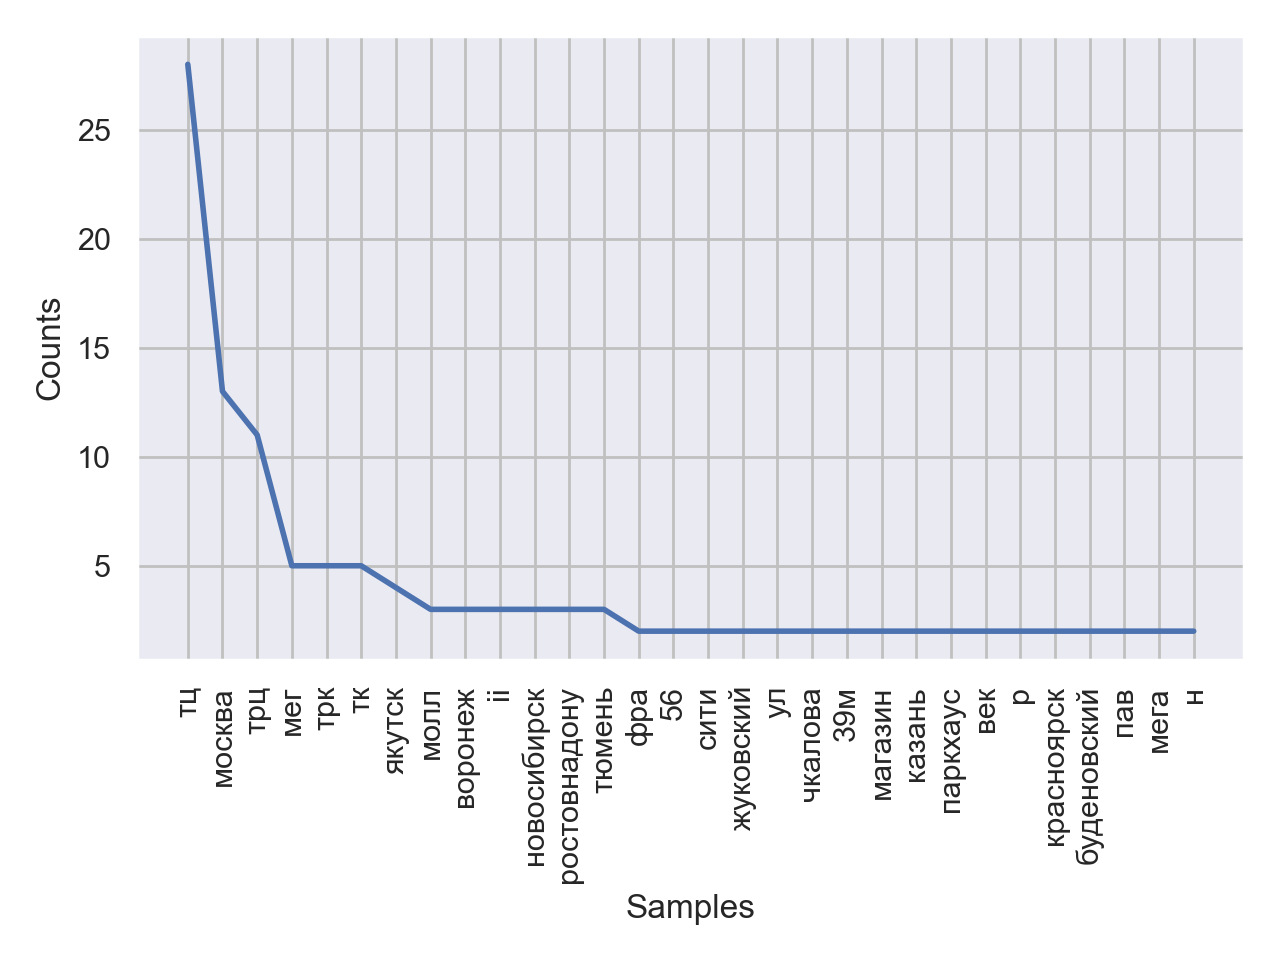

In [33]:
plt.figure()
fd_shop = nltk.FreqDist(shop_corpus_tokens)
fd_shop.plot(samples, cumulative=False)
plt.tight_layout()

We can see that a couple of words constitutes the most of the corpuses. In other words we can expect a high information gain from the first couple of features and diminishing returns as we add more words. We will from graphical inspection try with max features $35$ for TF-IDF for the item corpus, $25$ for the item category corpus and $10$ for the shop corpus. 

In [34]:
n_item_features = 35
n_item_category_features = 25
n_shop_features = 10

In [35]:
tf_idf_item_vec = sklearn.feature_extraction.text.TfidfVectorizer(max_features=n_item_features)
tf_idf_item = tf_idf_item_vec.fit_transform(item_nlp['item_name_nlp']).toarray()

In [36]:
tf_idf_item_category_vec = sklearn.feature_extraction.text.TfidfVectorizer(max_features=n_item_category_features)
tf_idf_item_category = tf_idf_item_category_vec.fit_transform(item_category_nlp['item_category_name_nlp']).toarray()

In [37]:
tf_idf_shop_vec = sklearn.feature_extraction.text.TfidfVectorizer(max_features=n_shop_features)
tf_idf_shop = tf_idf_shop_vec.fit_transform(shop_nlp['shop_name_nlp']).toarray()

Combine the TF-IDF results with the corresponding data frames

In [38]:
col_names = [f'item_tf_idf_{i}' for i in range(tf_idf_item.shape[1])]
tf_idf_item_df = pd.DataFrame(tf_idf_item, columns=col_names)
item_nlp = pd.concat([item_nlp, tf_idf_item_df], axis=1)
item_nlp.drop(['item_name', 'item_category_id', 'item_name_nlp'], axis=1, inplace=True)

In [39]:
col_names = [f'item_category_tf_idf_{i}' for i in range(tf_idf_item_category.shape[1])]
tf_idf_item_category_df = pd.DataFrame(tf_idf_item_category, columns=col_names)
item_category_nlp = pd.concat([item_category_nlp, tf_idf_item_category_df], axis=1)
item_category_nlp.drop(['item_category_name', 'item_category_name_nlp'], axis=1, inplace=True)

In [40]:
col_names = [f'shop_tf_idf_{i}' for i in range(tf_idf_shop.shape[1])]
tf_idf_shop_df = pd.DataFrame(tf_idf_shop, columns=col_names)
shop_nlp = pd.concat([shop_nlp, tf_idf_shop_df], axis=1)
shop_nlp.drop(['shop_name', 'shop_name_nlp'], axis=1, inplace=True)

## Dimensionality reduction

In order to save computational time, we would like to decrease the dimensionality of the corpus (as the tf-idf output is a relatively sparse matrix). As we will do this across item name, item category and shop name, we will gain the advantage of interaction between the words in our corpus.

Since the tf-idf outputs non-negative numbers, we can reduce the numbers using Non-negative Matrix Factorization.

In [41]:
corpus_aggregate = data_aggregate.loc[:, ['shop_id', 'item_id', 'item_category_id']].copy()
corpus_aggregate.drop_duplicates(inplace=True)
n_corpus_aggregate = corpus_aggregate.shape[0]

In [42]:
corpus_aggregate = pd.merge(corpus_aggregate, item_nlp.drop_duplicates(), how='left', on='item_id')
corpus_aggregate = pd.merge(corpus_aggregate, item_category_nlp.drop_duplicates(), how='left', on='item_category_id')
corpus_aggregate = pd.merge(corpus_aggregate, shop_nlp.drop_duplicates(), how='left', on='shop_id')

We reduce to $20 %$ of original dimension

In [43]:
n_new_dimensions = int((n_item_features + n_item_category_features + n_shop_features)*.20)

**NOTE:** We normally fit on the training set and transform on the test set. However, since the whole set is available for the training set, such split does not make sense here.

In [44]:
tf_idf_cols = [col for col in corpus_aggregate if '_tf_idf_' in col]

nmf = decomposition.NMF(n_components=n_new_dimensions)
reduced_corpus = nmf.fit_transform(corpus_aggregate[tf_idf_cols])

/Users/michaell/opt/anaconda3/envs/final_project/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "


In [45]:
nmf_cols = [f'nlp_nmf_{i}' for i in range(reduced_corpus.shape[1])]
reduced_corpus = pd.DataFrame(reduced_corpus, columns=nmf_cols)

In [46]:
corpus_aggregate = pd.concat([corpus_aggregate, reduced_corpus], axis=1)

In [47]:
if corpus_aggregate.isnull().any().any():
    raise AssertionError('NaNs were introduced in the corpus')
    
if corpus_aggregate.shape[0] > n_corpus_aggregate:
    raise AssertionError(f'The set was expanded: '
                         f'n_corpus_aggregate={n_corpus_aggregate} and '
                         f'corpus_aggregate.shape[0]={corpus_aggregate.shape[0]}')

In [48]:
del item_nlp
del item_category_nlp
del shop_nlp
del reduced_corpus
gc.collect()

30

# 4 Adding leakage features

The leakage features are features where we use information about the test set.

As both shop id and item id are features of the test set, and since these are not related to time, these are leakages.

### Number of ids in train and test

In [49]:
shop_id_train = sales_train.loc[:, 'shop_id']
shop_id_test = sales_test.loc[:, 'shop_id']
shop_id_both = pd.concat([shop_id_train, shop_id_test], axis=0).to_frame()
shop_id_both.loc[:, 'shop_id_count'] = shop_id_both.groupby('shop_id')['shop_id'].transform(len)

# NOTE: Drop duplicated as we want to merge
shop_id_both.drop_duplicates(inplace=True)

In [50]:
item_id_train = sales_train.loc[:, 'item_id']
item_id_test = sales_test.loc[:, 'item_id']
item_id_both = pd.concat([item_id_train, item_id_test], axis=0).to_frame()
item_id_both.loc[:, 'item_id_count'] = item_id_both.groupby('item_id')['item_id'].transform(len)

# NOTE: Drop duplicated as we want to merge
item_id_both.drop_duplicates(inplace=True)

Out of curiosity we check how these are distributed

<IPython.core.display.Javascript object>


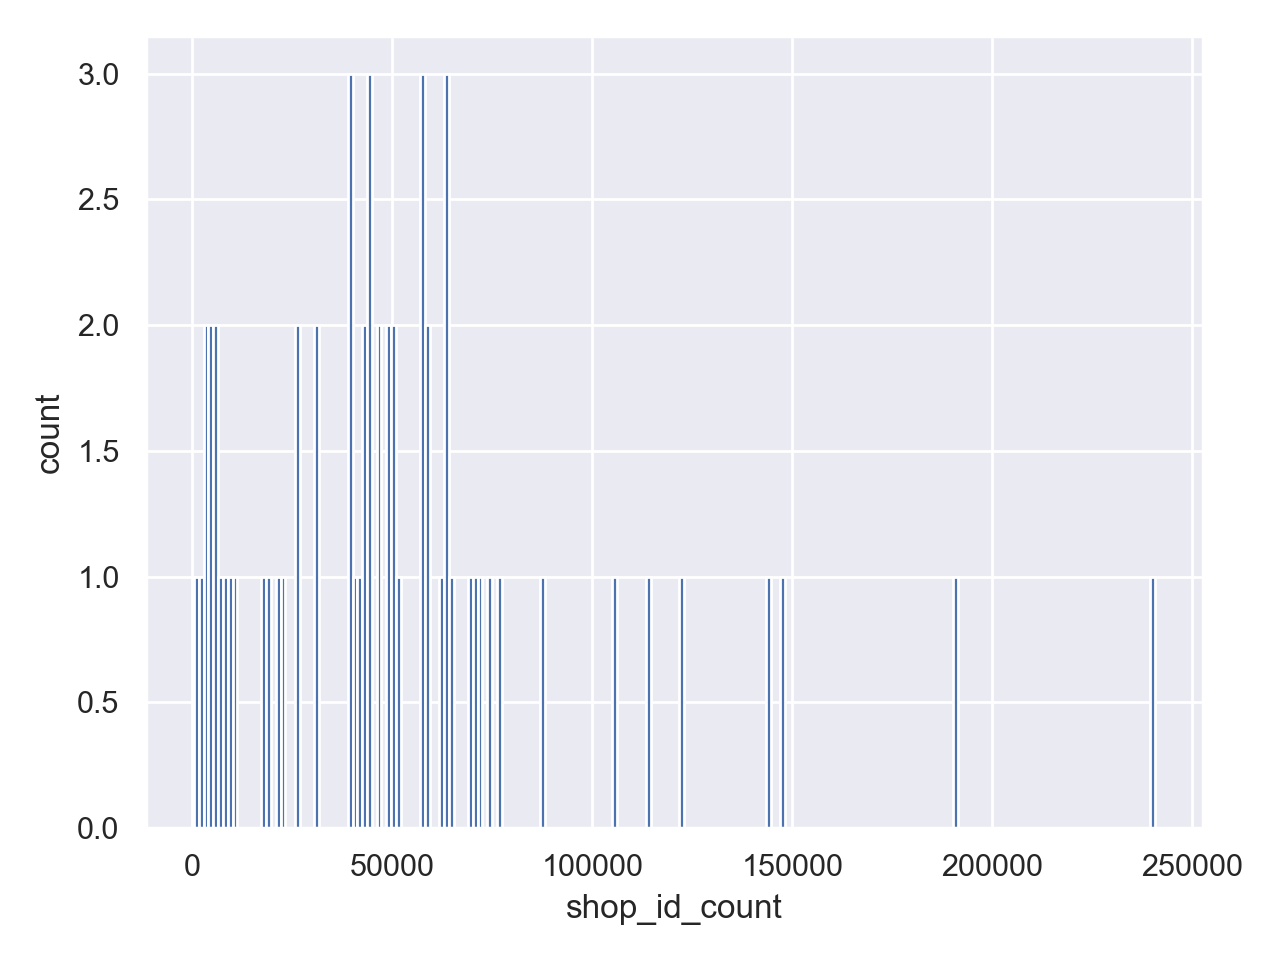

In [51]:
fig, ax = plt.subplots()
shop_id_both.loc[:, 'shop_id_count'].hist(ax=ax, bins=200)
ax.set_xlabel('shop_id_count')
ax.set_ylabel('count')
plt.tight_layout()

In [52]:
shop_id_both.loc[:, 'shop_id_count'].value_counts().describe()

count    60.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: shop_id_count, dtype: float64

It appears that the number of rows for each `shop_id` is well spread, and not clustering around a specific number

<IPython.core.display.Javascript object>


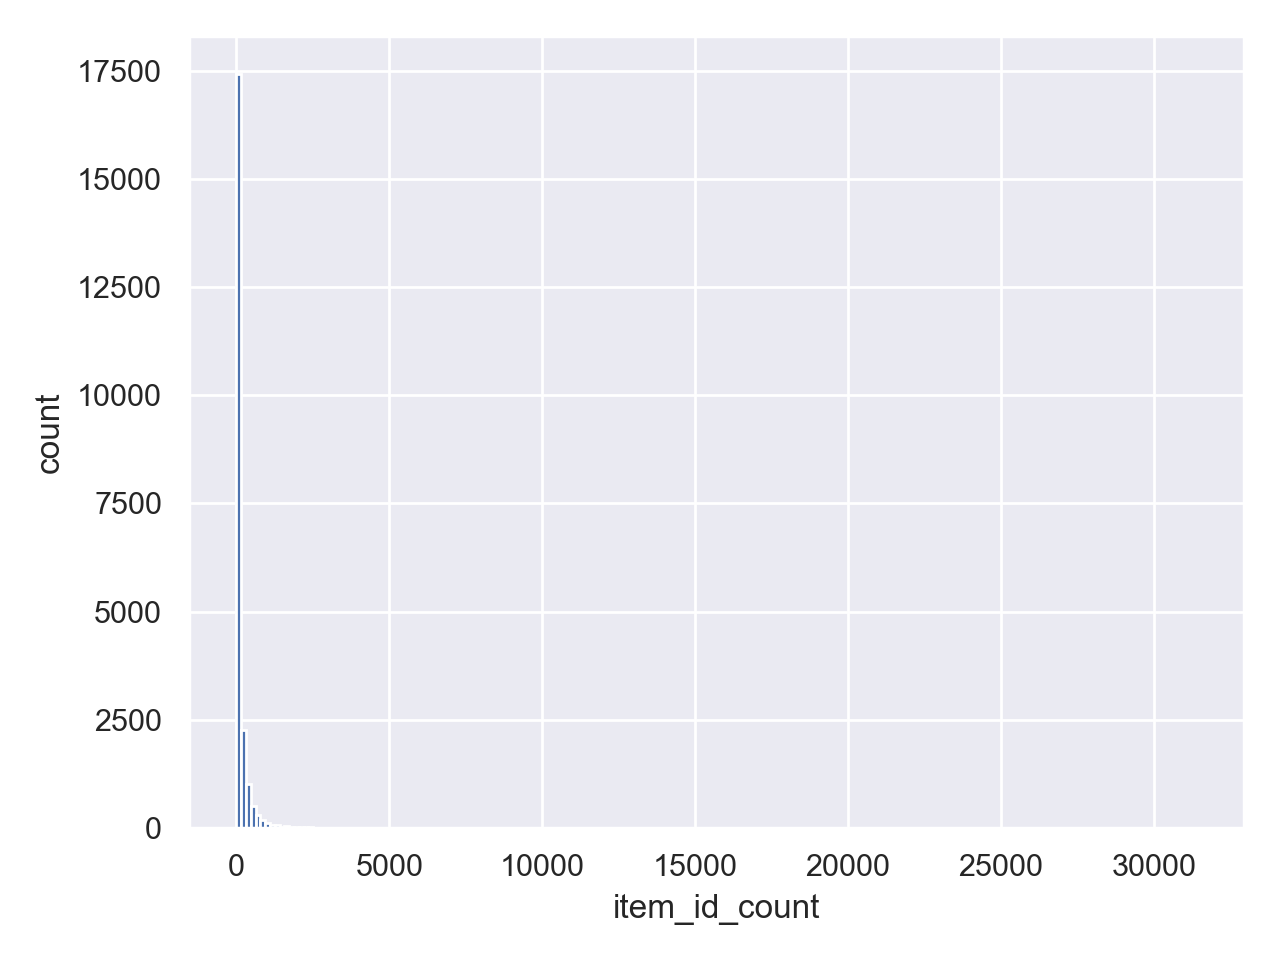

In [53]:
fig, ax = plt.subplots()
item_id_both.loc[:, 'item_id_count'].hist(ax=ax, bins=200)
ax.set_xlabel('item_id_count')
ax.set_ylabel('count')
plt.tight_layout()

In [54]:
item_id_both.loc[:, 'item_id_count'].value_counts().describe()

count    1288.000000
mean       17.212733
std        80.959628
min         1.000000
25%         1.000000
50%         2.000000
75%         9.000000
max      2288.000000
Name: item_id_count, dtype: float64

In [55]:
item_id_both.head()

,item_id,item_id_count
0,22154,101
1,2552,9
3,2554,1
4,2555,56
5,2564,46


### The ID

As we saw from the EDA, we saw that the `ID` was highly correlated to the `shop_id`, so we include it here. Item and shops without an ID will be given `-1` (although we could probably construct a more appropriate `ID` feature if we checked the feature more)

**NOTE**: We do an outer join here as some combinations of `shop_id` and `item_id` is only present in the test-set

In [56]:
on = ['shop_id', 'item_id']
id_df = pd.merge(sales_train.loc[:, on], sales_test, how='outer', on=['shop_id', 'item_id'])
id_df.loc[:,'ID'].fillna(-1, inplace=True)
id_df.loc[:,'ID'] = id_df.loc[:,'ID'].astype('int32')

### Additional leakage parameters

As the test set contains data after the train data, these will have a higher row number. Therefore, we could have added the row number as another leakage feature. However, as we has expanded the training set as we did when we added the aggregated features, we choose not to add this feature. In addition, we could be unlucky and have a test set which is shuffled with respect to the training set.

In [57]:
del shop_id_train
del shop_id_test
del item_id_train
del item_id_test

gc.collect()

20

# 5 The big merge

We are now ready to merge the different features into one big data frame

In [58]:
all_data = pd.merge(data_aggregate, dates, how='left', on='date_block_num')

In [59]:
all_data = pd.merge(all_data, corpus_aggregate, how='left', on=['shop_id', 'item_id', 'item_category_id'])

In [60]:
all_data = pd.merge(all_data, shop_id_both, how='left', on='shop_id')

In [61]:
all_data = pd.merge(all_data, item_id_both, how='left', on='item_id')

Item ID is a combination of `item_id` and `shop_id`. As before, if an ID doesn't exist for the combination, it will be assigned `-1`

In [62]:
all_data = pd.merge(all_data,
                    id_df.loc[:, ['item_id', 'shop_id', 'ID']].drop_duplicates(),
                    how='left',
                    on=['item_id', 'shop_id'])
all_data.loc[:, 'ID'].fillna(-1, inplace=True)
all_data.loc[:, 'ID'] = all_data.loc[:, 'ID'].astype('int32')

In [63]:
max_lag = max([int(col.split('_lag_')[-1]) for col in data_aggregate.columns if '_lag_' in col])
cols_wo_nan = [col for col in data_aggregate.columns if not ('month' in col and '_lag_' not in col)]

if all_data.loc[all_data.loc[:, 'date_block_num'] > max_lag, cols_wo_nan].isnull().any().any():
    raise AssertionError('NaNs were introduced in the data containing valid lags')
    
if all_data.shape[0] > n_train_samples:
    raise AssertionError(f'The set was expanded: '
                         f'n_train_samples={n_train_samples} and '
                         f'all_data.shape[0]={all_data.shape[0]}')

# 6 Type casting

In order to save resources, we downcast the types (as they by default are loaded as double)

In [64]:
def downcast_dtypes(df):
    """
    Downcasts float64 to float32 and int64 to int32
    
    Paramters
    ----------
    df : DataFrame
        The data frame to downcast
    
    Returns
    -------
    df : DataFrame
        The downcasted date frame
    """
    
    # Select columns to downcast
    float_cols = [c for c in df.columns if df.loc[:, c].dtype == 'float64']
    int_cols = [c for c in df.columns if df.loc[:, c].dtype == 'int64']
    
    # Downcast
    df.loc[:, float_cols] = df.loc[:, float_cols].astype(np.float32)
    df.loc[:, int_cols] = df.loc[:, int_cols].astype(np.int32)
    
    return df

In [65]:
all_data = downcast_dtypes(all_data)

We now store the full dataset in case we would like to modify it later on

In [66]:
sorted(all_data.columns)

['ID',
 'date_block_num',
 'days_in_month',
 'holiday_count',
 'item_category_id',
 'item_category_id_mean_mean_enc',
 'item_category_name_cyrillic_words',
 'item_category_name_latin_words',
 'item_category_name_total_words',
 'item_category_tf_idf_0',
 'item_category_tf_idf_1',
 'item_category_tf_idf_10',
 'item_category_tf_idf_11',
 'item_category_tf_idf_12',
 'item_category_tf_idf_13',
 'item_category_tf_idf_14',
 'item_category_tf_idf_15',
 'item_category_tf_idf_16',
 'item_category_tf_idf_17',
 'item_category_tf_idf_18',
 'item_category_tf_idf_19',
 'item_category_tf_idf_2',
 'item_category_tf_idf_20',
 'item_category_tf_idf_21',
 'item_category_tf_idf_22',
 'item_category_tf_idf_23',
 'item_category_tf_idf_24',
 'item_category_tf_idf_3',
 'item_category_tf_idf_4',
 'item_category_tf_idf_5',
 'item_category_tf_idf_6',
 'item_category_tf_idf_7',
 'item_category_tf_idf_8',
 'item_category_tf_idf_9',
 'item_id',
 'item_id_count',
 'item_id_mean_mean_enc',
 'item_name_cyrillic_words',

In [67]:
all_data.to_hdf(generated_data.joinpath('all_data.hdf'), key='all_data')

# 7 DataFrame trimming

We can now start to trim the dataset for features and rows which are not needed.
Firstly, since we are lagging the features up to `max_lag`, we will throw away the first `max_lag` values in our data set

In [68]:
trimmed_data = all_data.loc[all_data.loc[:, 'date_block_num'] > max_lag].copy()

We rename the target, so that the name matches the competition target name

In [69]:
old_target_name = 'month_shop_item_id_item_cnt_sum'
new_target_name = 'item_cnt_month'
trimmed_data.rename({old_target_name: new_target_name}, axis=1, inplace=True)

In [70]:
if trimmed_data.loc[trimmed_data.loc[:, 'date_block_num'] < 
                    trimmed_data.loc[:, 'date_block_num'].max(), new_target_name].isnull().any():
    raise AssertionError('NaNs were introduced in the target')

Next, we have some columns which has just been place-holders, and are now mean encoded

In [71]:
drop_cols = ['item_category_id', 
             'item_id', 
             'shop_id']

trimmed_data.drop(drop_cols, axis=1, inplace=True)

The columns which were used to create the lag is no longer needed

In [72]:
drop_cols = [col for col in trimmed_data.columns if 'month_' in col and '_lag_' not in col]
trimmed_data.drop(drop_cols, axis=1, inplace=True)

We reduced the dimensionality on the TF-IDF

In [73]:
drop_cols = [col for col in trimmed_data.columns if '_tf_idf_' in col]
trimmed_data.drop(drop_cols, axis=1, inplace=True)

In [74]:
sorted(trimmed_data.columns)

['ID',
 'date_block_num',
 'days_in_month',
 'holiday_count',
 'item_category_id_mean_mean_enc',
 'item_category_name_cyrillic_words',
 'item_category_name_latin_words',
 'item_category_name_total_words',
 'item_cnt_month',
 'item_id_count',
 'item_id_mean_mean_enc',
 'item_name_cyrillic_words',
 'item_name_latin_words',
 'item_name_total_words',
 'month',
 'month_item_cat_item_cnt_avg_lag_1',
 'month_item_cnt_avg_lag_1',
 'month_item_id_item_cnt_avg_lag_1',
 'month_item_id_item_cnt_max_lag_1',
 'month_item_id_item_cnt_min_lag_1',
 'month_item_id_item_cnt_sum_lag_1',
 'month_item_id_item_cnt_sum_lag_12',
 'month_item_id_item_cnt_sum_lag_2',
 'month_item_id_item_cnt_sum_lag_3',
 'month_item_id_item_cnt_sum_lag_6',
 'month_item_id_item_cnt_sum_lag_9',
 'month_shop_item_cat_item_cnt_avg_lag_1',
 'month_shop_item_cnt_avg_lag_1',
 'month_shop_item_cnt_sum_lag_1',
 'month_shop_item_cnt_sum_lag_12',
 'month_shop_item_cnt_sum_lag_2',
 'month_shop_item_cnt_sum_lag_3',
 'month_shop_item_cnt_sum_

In [75]:
if trimmed_data.drop(new_target_name, axis=1).isnull().any().any():
    raise AssertionError('NaNs were introduced')

We recall that tree-based models does not depend on the normalization. This means that we can use this data-set as-is.

In [76]:
trimmed_data.to_hdf(generated_data.joinpath('dt_data.hdf'), key='dt_data')

# 8 Normalization

If we are not using tree based methods, we should use normalize the data. Here we will use the `MaxMinScaler` on the ordinal features, and the `StandardScaler` (which keeps the information of the distribution intact) on the rest of the numerical features.

In a real world scenario we would be interested to fit a scale to a fold, and use the fitted scaling on the validation or the test fold as explained [here](https://stats.stackexchange.com/a/174865/132830). In this way we would not bias our scaling towards the test/validation-set, and we can assume that the generalization would perform better.

Here however, as we are in a competition setting, our primary goal is to optimize the loss metric of the competition. Thus, such a fallacy could be advantageous.

In [77]:
ordinal_features = ['ID',
                    'date_block_num',
                    'month',
                    'quarter',
                    'year']

In [78]:
max_min_scaler = sklearn.preprocessing.MinMaxScaler()
trimmed_data.loc[:, ordinal_features] = max_min_scaler.fit_transform(trimmed_data.loc[:, ordinal_features])

**NOTE**: We do not need to scale the target

In [79]:
nominal_features = set(trimmed_data.columns) - set(ordinal_features) - set([new_target_name])

In [80]:
standard_scaler = sklearn.preprocessing.StandardScaler()
trimmed_data.loc[:, nominal_features] = standard_scaler.fit_transform(trimmed_data.loc[:, nominal_features])

In [81]:
trimmed_data.to_hdf(generated_data.joinpath('non_dt_data.hdf'), key='non_dt_data')